In [1]:
!pip install timm

In [2]:
pip install -U git+https://github.com/facebookresearch/tome.git

  Cloning https://github.com/facebookresearch/tome.git to /tmp/pip-req-build-9_3x3d3t
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/tome.git /tmp/pip-req-build-9_3x3d3t
  Resolved https://github.com/facebookresearch/tome.git to commit af95e4b1befa172dadccd8c81e223b10090f9579
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 16.1 MB/s eta 0:00:00
  Created wheel for tome: filename=tome-0.1-py3-none-any.whl size=18279 sha256=9a5a8413b866d7290bac7d6d7a7a967cc60b86e91e194baa4bb340011221f017
  Stored in directory: /tmp/pip-ephem-wheel-cache-uzmgkuib/wheels/08/cf/e4/0483f82b5d5a41d2902b9d0f9875ee18541ec2049f4763e1ba
Successfully built tome
  Attempting uninstall: timm
    Found existing installation: timm 0.9.16
    Uninstalling timm-0.9.16:
      Successfully uninstalled timm-0.9.16
Note: you may need to restart the kernel to use updated packages.


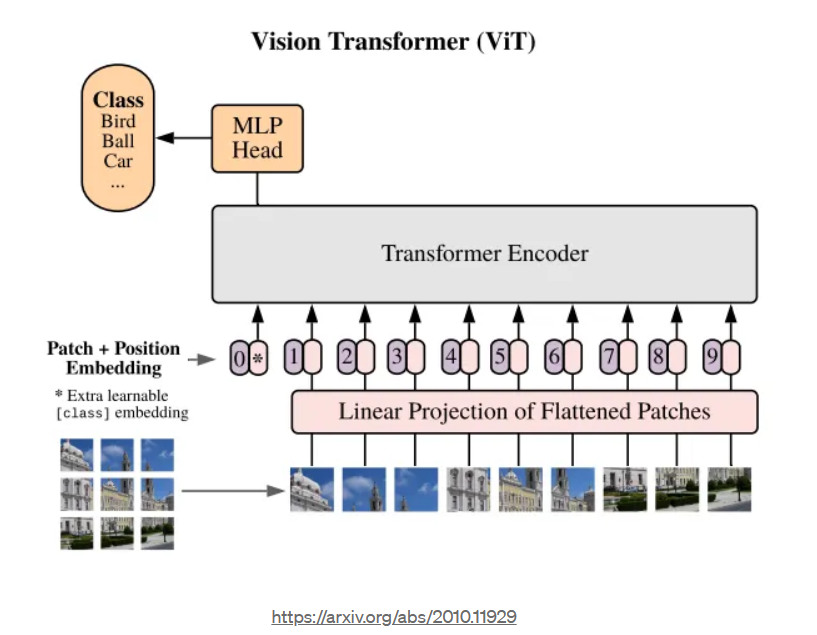

> EATD-Corpus:

Mandarin Dataset EATD-Corpus consists of audios and text transcripts extracted from the interviews of 162 student volunteers.
There are 30 depressed volunteers and 132 non-depressed volunteers in EATD-Corpus.
Self-Rating Depression Scale (SDS) is used.
The overall duration of response audios in the dataset is about 2.26 hours.


# Depression Classification using Multimodal Token Merging-Based Speech Spectro-Tempo Transformer


| Model        | Accuracy |
|--------------|----------|
| CNN          | 66%      |
| Normal VIT   | 83%      |

> Minutes of Last Meeting

- Make dual channel ToMe based transformer and check results
- Hypertune ToMe model for binary classification
- Do experiments on DAIC-WOZ (15 Hours Dataset)


In [3]:
import tome

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timm
from transformers import ViTForImageClassification, AutoImageProcessor, SwinForImageClassification, LevitForImageClassification

2024-03-30 14:26:17.425735: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 14:26:17.425862: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 14:26:17.553879: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Define a custom dataset class for dual-channel input
class DualChannelDataset(Dataset):
    def __init__(self, spectrogram_paths, tempogram_paths, labels, transform=None):
        self.spectrogram_paths = spectrogram_paths
        self.tempogram_paths = tempogram_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.spectrogram_paths)

    def __getitem__(self, idx):
        spectrogram_path = self.spectrogram_paths[idx]
        tempogram_path = self.tempogram_paths[idx]

        spectrogram_image = Image.open(spectrogram_path).convert("RGB")
        tempogram_image = Image.open(tempogram_path).convert("RGB")

        if self.transform:
            spectrogram_image = self.transform(spectrogram_image)
            tempogram_image = self.transform(tempogram_image)

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return {"spectrogram": spectrogram_image, "tempogram": tempogram_image}, label



In [7]:
# Define data directories
train_spectrogram_dir = "/kaggle/input/eatd-spec-final/specs_final/train_spectrograms"
train_tempogram_dir = "/kaggle/input/eatd-tempo-augmented/EATD_tempo_augmented/train_tempo"
test_spectrogram_dir = "/kaggle/input/eatd-spec-final/specs_final/test_spectrograms"
test_tempogram_dir = "/kaggle/input/eatd-tempo-augmented/EATD_tempo_augmented/test_tempo"

# Initialize lists to store file paths and labels
train_spectrogram_files = []
train_tempogram_files = []
train_labels = []
test_spectrogram_files = []
test_tempogram_files = []
test_labels = []

# Define class labels
class_labels = ["depressed", "non_depressed"]

# List of time durations
time_durations = ["25ms", "400ms"]

# Iterate through class labels and time durations to collect file paths and labels
for label in class_labels:
    for duration in time_durations:
        train_spectrogram_folder = os.path.join(train_spectrogram_dir, label, duration)
        train_tempogram_folder = os.path.join(train_tempogram_dir, label, duration)

        train_spectrogram_files.extend([os.path.join(train_spectrogram_folder, filename) for filename in os.listdir(train_spectrogram_folder)])
        train_tempogram_files.extend([os.path.join(train_tempogram_folder, filename) for filename in os.listdir(train_tempogram_folder)])
        train_labels.extend([1 if label == "depressed" else 0] * len(os.listdir(train_spectrogram_folder)))

        test_spectrogram_folder = os.path.join(test_spectrogram_dir, label, duration)
        test_tempogram_folder = os.path.join(test_tempogram_dir, label, duration)

        test_spectrogram_files.extend([os.path.join(test_spectrogram_folder, filename) for filename in os.listdir(test_spectrogram_folder)])
        test_tempogram_files.extend([os.path.join(test_tempogram_folder, filename) for filename in os.listdir(test_tempogram_folder)])
        test_labels.extend([1 if label == "depressed" else 0] * len(os.listdir(test_spectrogram_folder)))


In [8]:
class DualChannelModel(nn.Module):
    def __init__(self, spectrogram_model, tempogram_model, num_classes):
        super(DualChannelModel, self).__init__()
        self.spectrogram_model = spectrogram_model
        self.tempogram_model = tempogram_model

        # Access the hidden size directly
        self.spectrogram_feature_size = spectrogram_model.embed_dim
        self.tempogram_feature_size = tempogram_model.embed_dim

        # Assuming that the last layer of each model is the classification layer
        self.spectrogram_classifier = nn.Linear(self.spectrogram_feature_size, num_classes)
        self.tempogram_classifier = nn.Linear(self.tempogram_feature_size, num_classes)

        # Modify the following line to use the correct attribute name
        self.output_classifier = nn.Linear(2 * num_classes, num_classes)

    def forward(self, spectrogram_input, tempogram_input):
        # Forward pass for the spectrogram model
        spectrogram_output = self.spectrogram_model(spectrogram_input)
        # Forward pass for the tempogram model
        tempogram_output = self.tempogram_model(tempogram_input)

        # Perform any other operations on the outputs if needed
        # For example, you can apply a global average pooling layer

        # Final classification using a common linear layer
        combined_features = torch.cat([spectrogram_output, tempogram_output], dim=1)
        output = self.output_classifier(combined_features)

        return output

model_name = "vit_base_patch16_224"
model_name_1 = "vit_base_patch16_224"
# Initialize the ViT models
spectrogram_model = timm.create_model(model_name, pretrained=True, num_classes=2)
tome.patch.timm(spectrogram_model)
spectrogram_model.r = 8
tempogram_model = timm.create_model(model_name_1, pretrained=True, num_classes=2)
tome.patch.timm(tempogram_model)
tempogram_model.r = 8

# Modify the classification head for two classes
num_classes = 2
spectrogram_model.head = nn.Linear(spectrogram_model.embed_dim, num_classes)
tempogram_model.head = nn.Linear(tempogram_model.embed_dim, num_classes)

# Initialize the DualChannelModel
dual_channel_model = DualChannelModel(spectrogram_model, tempogram_model, num_classes)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dual_channel_model.parameters(), lr=3e-5)


In [9]:
from torchvision.transforms import (CenterCrop, Compose, Normalize,
                                    RandomRotation, RandomResizedCrop,
                                    RandomHorizontalFlip, RandomAdjustSharpness,
                                    Resize, ToTensor)
from torchvision.transforms.functional import InterpolationMode
import torchvision

# processor = AutoImageProcessor.from_pretrained(model_name)
# # Get image mean, std, and size
# image_mean, image_std = processor.image_mean, processor.image_std
# #size = processor.size["height"]

# # Define image normalization
# normalize = Normalize(mean=image_mean, std=image_std)
# # Define transformations for data augmentation
# data_transforms = transforms.Compose([
#     Resize((224, 224)),
#     RandomRotation(15),
#     RandomAdjustSharpness(2),
#     ToTensor(),
#     normalize,  # Assuming `normalize` is defined as specified in the previous code
# ])
input_size = spectrogram_model.default_cfg["input_size"][1]

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(int((256 / 224) * input_size), interpolation=InterpolationMode.BICUBIC),
    torchvision.transforms.CenterCrop(input_size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(spectrogram_model.default_cfg["mean"], spectrogram_model.default_cfg["std"]),
])


# Create dataset objects
train_dataset = DualChannelDataset(train_spectrogram_files, train_tempogram_files, train_labels, transform=transforms)
test_dataset = DualChannelDataset(test_spectrogram_files, test_tempogram_files, test_labels, transform=transforms)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [10]:
# Training loop
num_epochs = 30
early_stopping_patience = 3
best_training_loss = np.inf
consecutive_no_improvement = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dual_channel_model.to(device)

for epoch in range(num_epochs):
    dual_channel_model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        spectrogram_images, tempogram_images = batch[0]["spectrogram"].to(device), batch[0]["tempogram"].to(device)
        labels = batch[1].to(device)

        optimizer.zero_grad()

        outputs = dual_channel_model(spectrogram_images, tempogram_images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    training_accuracy = correct_predictions / total_predictions

    if running_loss < best_training_loss:
        best_training_loss = running_loss
        consecutive_no_improvement = 0
    else:
        consecutive_no_improvement += 1

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}, Training Accuracy: {training_accuracy}")

    if consecutive_no_improvement >= early_stopping_patience:
        print(f"No improvement for {early_stopping_patience} consecutive epochs. Early stopping.")
        break

Epoch 1/30, Loss: 0.8050609244143262, Training Accuracy: 0.7415730337078652
Epoch 2/30, Loss: 0.20811201325234244, Training Accuracy: 0.9250936329588015
Epoch 3/30, Loss: 0.14299332460059838, Training Accuracy: 0.9419475655430711
Epoch 4/30, Loss: 0.07283537144608357, Training Accuracy: 0.9775280898876404
Epoch 5/30, Loss: 0.04510549855801989, Training Accuracy: 0.9850187265917603
Epoch 6/30, Loss: 0.1620742654263535, Training Accuracy: 0.9400749063670412
Epoch 7/30, Loss: 0.06859854816952173, Training Accuracy: 0.9737827715355806
Epoch 8/30, Loss: 0.055732312776586586, Training Accuracy: 0.9775280898876404
No improvement for 3 consecutive epochs. Early stopping.


Test Accuracy: 0.9195979899497487
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.99      0.93       200
           1       0.99      0.85      0.91       198

    accuracy                           0.92       398
   macro avg       0.93      0.92      0.92       398
weighted avg       0.93      0.92      0.92       398

Confusion Matrix:
[[198   2]
 [ 30 168]]


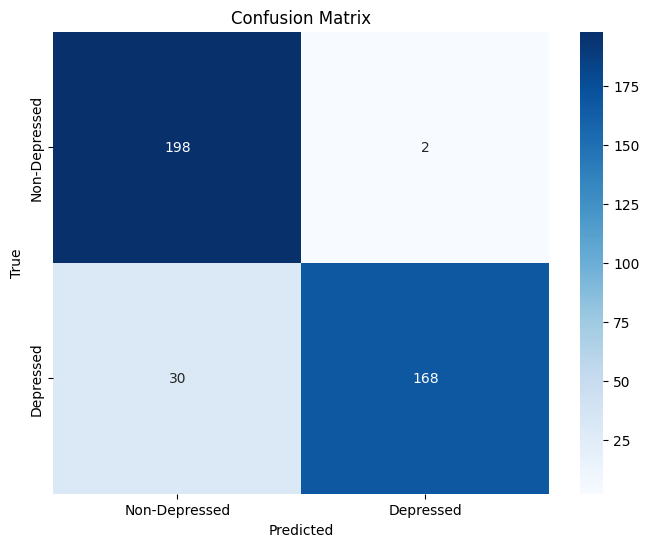

In [11]:
# Evaluate the dual-channel model on the test set
dual_channel_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        spectrogram_images, tempogram_images = batch[0]["spectrogram"].to(device), batch[0]["tempogram"].to(device)
        labels = batch[1].to(device)

        outputs = dual_channel_model(spectrogram_images, tempogram_images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy}")

# Generate classification report
report = classification_report(all_labels, all_preds)
print("Classification Report:\n", report)

# Calculate and print the confusion matrix
confusion = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(confusion)

# Plot the confusion matrix (optional)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Depressed", "Depressed"], yticklabels=["Non-Depressed", "Depressed"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


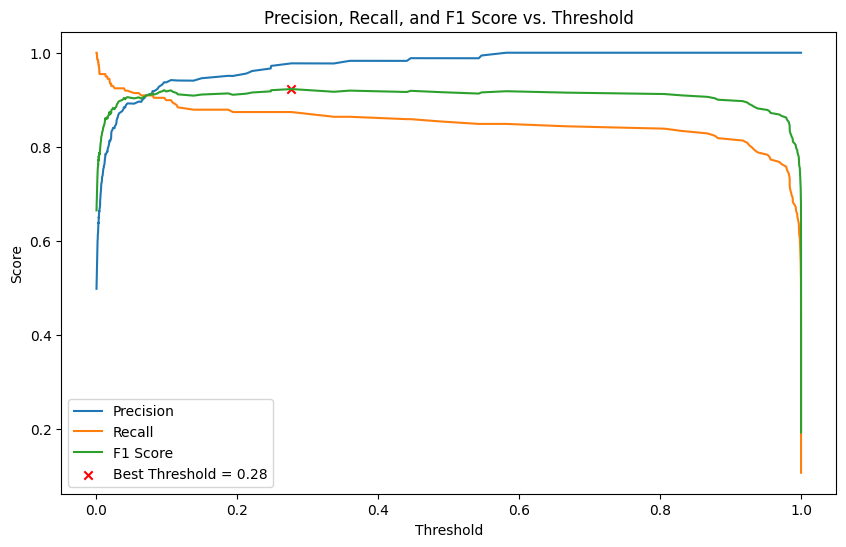

Best Threshold: 0.28


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

with torch.no_grad():
    all_probs = []

    for batch in test_loader:
        spectrogram_images, tempogram_images = batch[0]["spectrogram"].to(device), batch[0]["tempogram"].to(device)
        labels = batch[1].to(device)
        outputs = dual_channel_model(spectrogram_images, tempogram_images)
        # Apply softmax manually
        probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]
        all_probs.extend(probs.cpu().numpy())

# Convert lists to NumPy arrays
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)

# Calculate F1 score for each threshold
f1_scores = [f1_score(all_labels, all_probs >= threshold) for threshold in thresholds]

# Find the threshold that maximizes F1 score
best_threshold = thresholds[np.argmax(f1_scores)]

# Plot precision, recall, and F1 score vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')

# Mark the threshold that maximizes F1 score
plt.scatter(best_threshold, max(f1_scores), color='red', marker='x', label=f'Best Threshold = {best_threshold:.2f}')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend()
plt.show()

print(f"Best Threshold: {best_threshold:.2f}")


Updated Test Accuracy: 92.71%
Updated Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93       200
           1       0.98      0.87      0.92       198

    accuracy                           0.93       398
   macro avg       0.93      0.93      0.93       398
weighted avg       0.93      0.93      0.93       398

Updated Confusion Matrix:
[[196   4]
 [ 25 173]]


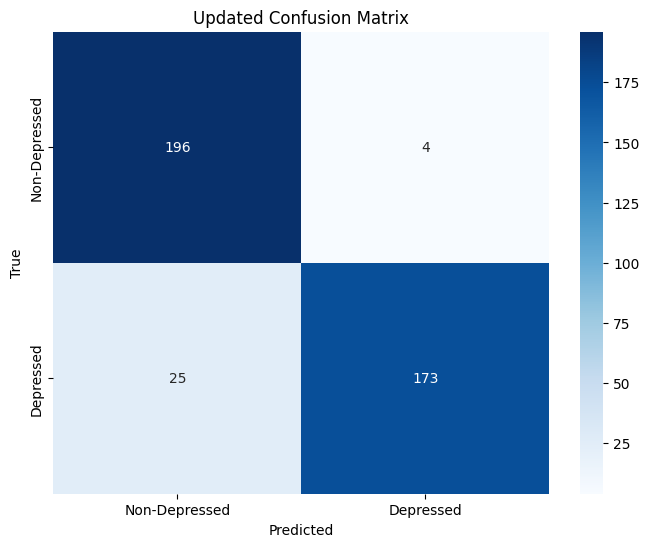

In [14]:
# Apply the best threshold to classify instances
thresholded_preds = (all_probs >= best_threshold).astype(int)

# Calculate updated accuracy
updated_accuracy = accuracy_score(all_labels, thresholded_preds)

# Print updated test accuracy
print(f"Updated Test Accuracy: {updated_accuracy:.2%}")

# Print updated classification report
updated_report = classification_report(all_labels, thresholded_preds)
print("Updated Classification Report:\n", updated_report)

# Calculate and print the confusion matrix for the updated predictions
updated_confusion = confusion_matrix(all_labels, thresholded_preds)
print("Updated Confusion Matrix:")
print(updated_confusion)

# Plot the updated confusion matrix (optional)
plt.figure(figsize=(8, 6))
sns.heatmap(updated_confusion, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Depressed", "Depressed"], yticklabels=["Non-Depressed", "Depressed"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Updated Confusion Matrix")
plt.show()

In [15]:
print(dual_channel_model)

DualChannelModel(
  (spectrogram_model): ToMeVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): ToMeBlock(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): ToMeAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=Fals